In [880]:
import numpy as np
import pandas as pd
from functools import reduce
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
#pd.set_option("precision",4)

In [1369]:
# df_betas: daily portfolio(P1 to P10, BAB) betas
# df_returns: daily portfolio(P1 to P10, BAB) returns

# US

## Market Data

In [881]:
df_CRSP_market_daily=pd.read_csv('../data/CRSP/CRSP Daily Index Built on Market Capitalization.csv',\
index_col=0,parse_dates=True)

In [882]:
df_CRSP_market_daily =df_CRSP_market_daily[['vwretd']]['2001-01-01':'2020-12-31']

In [883]:
df_AQR_risk_free_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='RF',header=18,index_col=0,parse_dates=True)
df_AQR_risk_free_daily= df_AQR_risk_free_daily['2001-01-01':'2020-12-31']

In [892]:
df_AQR_MKT_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='MKT',header=18,index_col=0,parse_dates=True)
df_AQR_MKT_daily= df_AQR_MKT_daily['2001-01-01':'2020-12-31']

In [893]:
df_FF_5=pd.read_csv('../data/FF_Factors/F-F_Research_Data_5_Factors_2x3_daily.csv',index_col=0,parse_dates=True)
df_FF_5 = df_FF_5['2001-01-01':'2020-12-31']/100

In [894]:
df_FF_5

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2001-01-02,-0.0352,0.0039,0.0165,0.0158,0.0161,0.00026
2001-01-03,0.0539,-0.0065,-0.0439,-0.0266,-0.0594,0.00026
2001-01-04,-0.0130,0.0097,-0.0030,0.0052,-0.0080,0.00026
2001-01-05,-0.0298,0.0071,0.0238,0.0190,0.0231,0.00026
2001-01-08,-0.0036,-0.0043,0.0126,0.0098,0.0067,0.00026
...,...,...,...,...,...,...
2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.00000
2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.00000
2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.00000


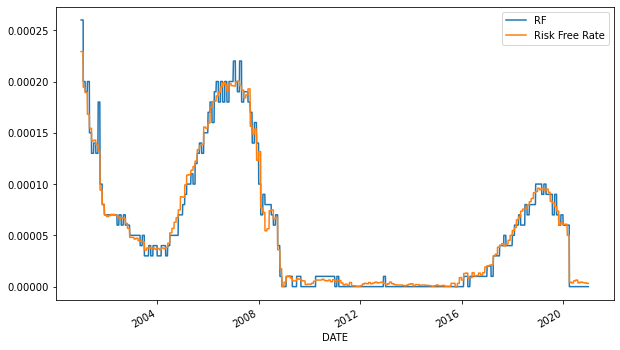

In [895]:
fig, ax =plt.subplots(figsize=(10,6))

df_FF_5.RF.plot(ax=ax)
(df_AQR_risk_free_daily).plot(ax=ax)

plt.legend()

In [896]:
dfs_market_merged=[df_FF_5[['Mkt-RF']],df_CRSP_market_daily[['vwretd']],df_AQR_MKT_daily[['USA']]]
dfs_market_merged=reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),dfs_market_merged)

<AxesSubplot:>

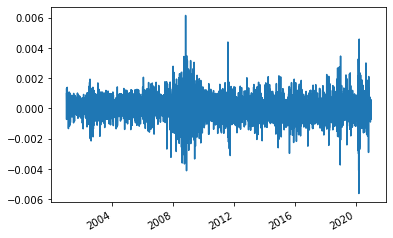

In [897]:
(dfs_market_merged['vwretd']-dfs_market_merged['Mkt-RF']).plot()

In [898]:
dfs_market_merged

,Mkt-RF,vwretd,USA
2001-01-02,-0.0352,-0.034230,-0.034543
2001-01-03,0.0539,0.053170,0.053313
2001-01-04,-0.0130,-0.011674,-0.010935
2001-01-05,-0.0298,-0.028909,-0.028499
2001-01-08,-0.0036,-0.003410,-0.003914
...,...,...,...
2020-12-24,0.0021,0.002332,0.002347
2020-12-28,0.0046,0.003870,0.003893
2020-12-29,-0.0040,-0.003649,-0.003812
2020-12-30,0.0027,0.003281,0.003364


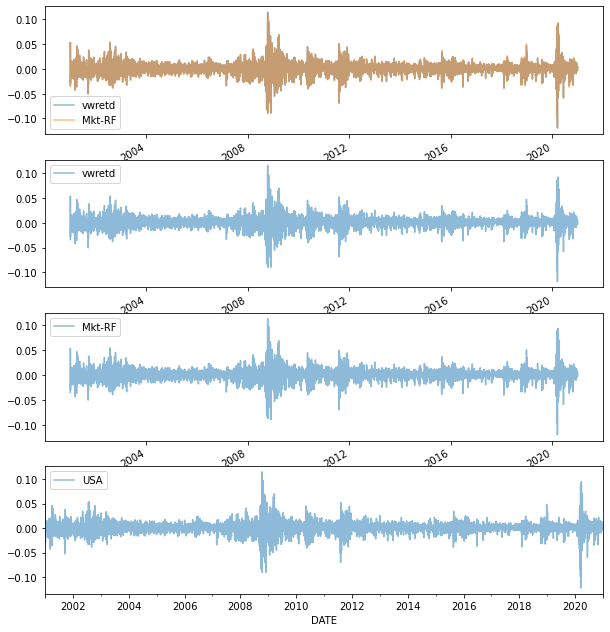

In [899]:
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,12))

(df_CRSP_market_daily.vwretd).plot(ax=ax[0],alpha=0.5)
df_FF_5['Mkt-RF'].plot(ax=ax[0],alpha=0.5)

(df_CRSP_market_daily.vwretd).plot(ax=ax[1],alpha=0.5)

df_FF_5['Mkt-RF'].plot(ax=ax[2],alpha=0.5)

df_AQR_MKT_daily['USA'].plot(ax=ax[3],alpha=0.5)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

## Construct the Table 3 and Table 4

In [1285]:
def get_alpha(df, factors,portfolio):
    x = df[factors].copy()
    x = sm.add_constant(x)
    results = sm.OLS(df[portfolio], x).fit(cov_type='HC1')
    return results.params[0],results.params[1],results.tvalues[0]

In [1370]:
df_betas=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/beta.pickle')
df_returns=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/return.pickle')
df_betas = df_betas.astype('float64')
df_returns = df_returns.astype('float64')

<AxesSubplot:>

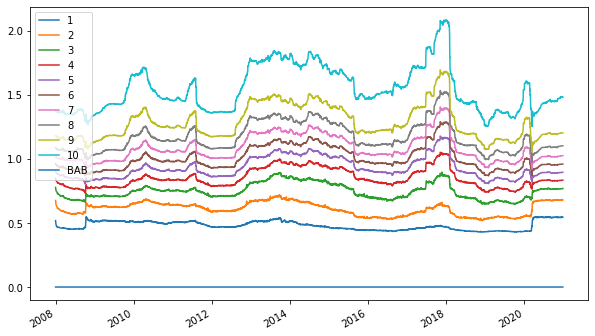

In [1371]:
df_betas.rolling(1).mean().plot(figsize=(10,6))

<AxesSubplot:>

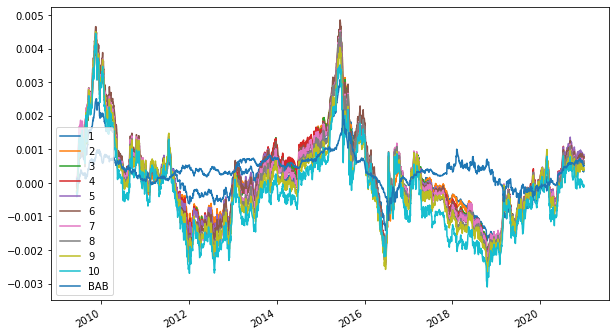

In [1342]:
df_returns.rolling(252).mean().plot(figsize=(10,6))

In [1343]:
df_Port_FF5=df_returns.merge(df_FF_5,left_index=True,right_index=True)
df_Port_FF5 = df_Port_FF5.dropna()

In [1344]:
def get_table_3_4(df):
    df_table_3=pd.DataFrame(index=['Excess Return','CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha','Beta(ex ante)','Beta(realized)','Volatility','Sharpe Ratio'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    df_table_4=pd.DataFrame(index=['CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    
    columns = np.concatenate((np.arange(1,11,1), ['BAB'])).astype(str)

    df_table_3.loc[df_table_3.index=='Excess Return',:]=\
    ((((1+df).cumprod().iloc[-1,:11])**(252/len(df))-1)*100).values/12

    df_table_3.loc[df_table_3.index=='CAPM alpha',:]=\
    [(get_alpha(df,['Mkt-RF'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Three-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Four-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Five-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Beta(ex ante)',:]=\
    df_betas.mean().values

    df_table_3.loc[df_table_3.index=='Beta(realized)',:]=\
    [get_alpha(df,['Mkt-RF'],i)[1] for i in columns]

    df_table_3.loc[df_table_3.index=='Volatility',:]=\
    [df[i].std()*np.sqrt(252)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Sharpe Ratio',:]=\
    (df_table_3.loc['Excess Return']*12/df_table_3.loc['Volatility'])[:].values
    
    df_table_4.loc[df_table_4.index=='CAPM alpha',:]=\
    [get_alpha(df,['Mkt-RF'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Three-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Four-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Five-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[2] for i in columns]

    return df_table_3,df_table_4

In [1345]:
df_Port_FF5.index

DatetimeIndex(['2008-05-30', '2008-06-02', '2008-06-03', '2008-06-04',
               '2008-06-05', '2008-06-06', '2008-06-10', '2008-06-11',
               '2008-06-12', '2008-06-13',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=2940, freq=None)

### All data: 2008-2020

In [1360]:
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5['2008-01-01':'2020-12-31'])

In [1361]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.102162,-0.071379,-0.0881067,-0.0459007,-0.124303,-0.183528,-0.399103,-0.653146,-0.865171,-1.40518,0.686342
CAPM alpha,0.122461,0.0524329,0.0926974,0.171332,0.133539,0.110068,-0.108461,-0.371492,-0.582253,-1.19546,0.742576
Three-factor alpha,0.0977718,0.000484299,0.0270855,0.100406,0.0593373,0.0317415,-0.184812,-0.455836,-0.666243,-1.29223,0.755917
Four-factor alpha,0.103857,0.0132554,0.0323908,0.106718,0.0657468,0.0366399,-0.180301,-0.450063,-0.659251,-1.28763,0.759387
Five-factor alpha,0.114132,0.0271807,0.0456144,0.120205,0.0818517,0.0521443,-0.164894,-0.434715,-0.643212,-1.26949,0.763778
Beta(ex ante),0.583713,0.80115,0.872794,0.921731,0.960864,0.995358,1.02836,1.06395,1.10909,1.19935,0
Beta(realized),0.0614682,0.109561,0.117632,0.130815,0.13048,0.132111,0.138151,0.14567,0.150171,0.161135,-0.00777306
Volatility,13.285,23.1943,26.2049,28.1714,29.9078,31.4066,32.1775,33.1646,34.4381,36.1212,10.0191
Sharpe Ratio,0.09228,-0.0369292,-0.0403467,-0.019552,-0.0498743,-0.0701234,-0.148838,-0.236329,-0.30147,-0.466821,0.822041


In [1362]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,0.361002,0.088436,0.138161,0.23764,0.174273,0.136859,-0.131654,-0.437758,-0.660966,-1.29453,2.89505
Three-factor alpha,0.28818,0.000816926,0.0403908,0.139308,0.0774804,0.0395051,-0.224428,-0.537425,-0.756825,-1.40017,2.95387
Four-factor alpha,0.306522,0.0223637,0.0483422,0.148207,0.085938,0.0456735,-0.219246,-0.531339,-0.750109,-1.39719,2.96918
Five-factor alpha,0.33687,0.0458131,0.0680147,0.166764,0.106898,0.0649438,-0.200344,-0.512714,-0.731268,-1.37666,2.98523


### Expansion Phrase: 2009-2019

In [1363]:
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5['2009-01-01':'2020-12-31'])

In [1364]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.374067,0.438529,0.429923,0.478778,0.405908,0.386048,0.100634,-0.128067,-0.349872,-0.935836,0.778312
CAPM alpha,0.359101,0.478316,0.507792,0.575733,0.537768,0.552153,0.277154,0.0465199,-0.163496,-0.793822,0.838138
Three-factor alpha,0.341359,0.448195,0.473448,0.542357,0.500791,0.511983,0.236075,0.00138845,-0.209758,-0.851162,0.84251
Four-factor alpha,0.342481,0.451444,0.473253,0.544971,0.502963,0.513026,0.237442,0.0043849,-0.206887,-0.848621,0.839684
Five-factor alpha,0.354947,0.468393,0.490144,0.564505,0.526337,0.537835,0.261431,0.0304008,-0.18138,-0.818784,0.839828
Beta(ex ante),0.583713,0.80115,0.872794,0.921731,0.960864,0.995358,1.02836,1.06395,1.10909,1.19935,0
Beta(realized),0.0815117,0.148215,0.160338,0.17831,0.181671,0.185339,0.189996,0.202791,0.208681,0.220447,-0.014393
Volatility,13.0828,21.8997,24.47,26.316,27.9253,29.4208,30.2353,31.1588,32.4534,34.1276,9.68951
Sharpe Ratio,0.343108,0.240294,0.210833,0.218321,0.174426,0.157459,0.0399404,-0.0493218,-0.129369,-0.32906,0.963904


In [1365]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,1.04684,0.833063,0.790562,0.83368,0.733237,0.714875,0.349282,0.0569355,-0.192213,-0.888181,3.29362
Three-factor alpha,0.99403,0.780125,0.736597,0.784945,0.68257,0.66271,0.297323,0.00169838,-0.24649,-0.951486,3.3143
Four-factor alpha,0.998526,0.785665,0.736499,0.789011,0.68576,0.664512,0.2992,0.00536674,-0.243268,-0.949083,3.30115
Five-factor alpha,1.03544,0.8151,0.762714,0.817071,0.717515,0.696715,0.329424,0.0372021,-0.213274,-0.915919,3.29962


### 2009-2020

In [1366]:
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5['2009-01-01':'2020-12-31'])

In [1367]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.374067,0.438529,0.429923,0.478778,0.405908,0.386048,0.100634,-0.128067,-0.349872,-0.935836,0.778312
CAPM alpha,0.359101,0.478316,0.507792,0.575733,0.537768,0.552153,0.277154,0.0465199,-0.163496,-0.793822,0.838138
Three-factor alpha,0.341359,0.448195,0.473448,0.542357,0.500791,0.511983,0.236075,0.00138845,-0.209758,-0.851162,0.84251
Four-factor alpha,0.342481,0.451444,0.473253,0.544971,0.502963,0.513026,0.237442,0.0043849,-0.206887,-0.848621,0.839684
Five-factor alpha,0.354947,0.468393,0.490144,0.564505,0.526337,0.537835,0.261431,0.0304008,-0.18138,-0.818784,0.839828
Beta(ex ante),0.583713,0.80115,0.872794,0.921731,0.960864,0.995358,1.02836,1.06395,1.10909,1.19935,0
Beta(realized),0.0815117,0.148215,0.160338,0.17831,0.181671,0.185339,0.189996,0.202791,0.208681,0.220447,-0.014393
Volatility,13.0828,21.8997,24.47,26.316,27.9253,29.4208,30.2353,31.1588,32.4534,34.1276,9.68951
Sharpe Ratio,0.343108,0.240294,0.210833,0.218321,0.174426,0.157459,0.0399404,-0.0493218,-0.129369,-0.32906,0.963904


In [1368]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,1.04684,0.833063,0.790562,0.83368,0.733237,0.714875,0.349282,0.0569355,-0.192213,-0.888181,3.29362
Three-factor alpha,0.99403,0.780125,0.736597,0.784945,0.68257,0.66271,0.297323,0.00169838,-0.24649,-0.951486,3.3143
Four-factor alpha,0.998526,0.785665,0.736499,0.789011,0.68576,0.664512,0.2992,0.00536674,-0.243268,-0.949083,3.30115
Five-factor alpha,1.03544,0.8151,0.762714,0.817071,0.717515,0.696715,0.329424,0.0372021,-0.213274,-0.915919,3.29962


## BAB Factor Comparison

In [1299]:
df_BAB_comparison=df_AQR_BAB_daily[['USA']].merge(df_returns[['BAB']],left_index=True,right_index=True)

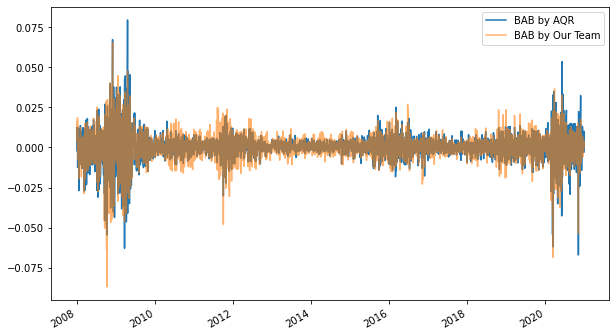

In [1300]:
fig, ax =plt.subplots(figsize=(10,6))

df_BAB_comparison['USA'].plot(ax=ax,label='BAB by AQR')
df_BAB_comparison['BAB'].plot(ax=ax,label='BAB by Our Team',alpha=0.6)

plt.legend()

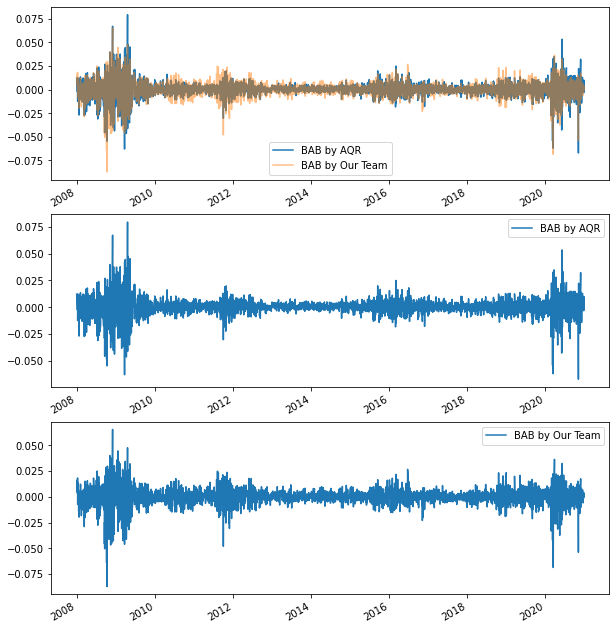

In [1301]:
fig, ax =plt.subplots(nrows=3,ncols=1,figsize=(10,12))

df_BAB_comparison['USA'].plot(ax=ax[0],label='BAB by AQR')
df_BAB_comparison['BAB'].plot(ax=ax[0],label='BAB by Our Team',alpha=0.5)
df_BAB_comparison['USA'].plot(ax=ax[1],label='BAB by AQR')
df_BAB_comparison['BAB'].plot(ax=ax[2],label='BAB by Our Team')


ax[0].legend()
ax[1].legend()
ax[2].legend()


# China

## Construct the Table 3 and Table 4

In [1373]:
df_betas=pd.read_pickle('../output/China/Portfolio Beta and Return Daily/beta.pickle')
df_returns=pd.read_pickle('../output/China/Portfolio Beta and Return Daily/return.pickle')
df_betas = df_betas.astype('float64')
df_returns = df_returns.astype('float64')

<AxesSubplot:>

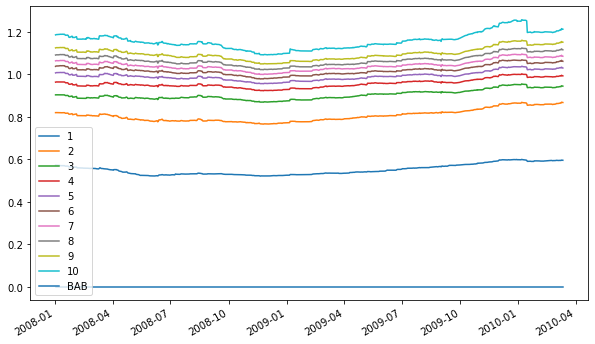

In [1374]:
df_betas.rolling(1).mean().plot(figsize=(10,6))

<AxesSubplot:>

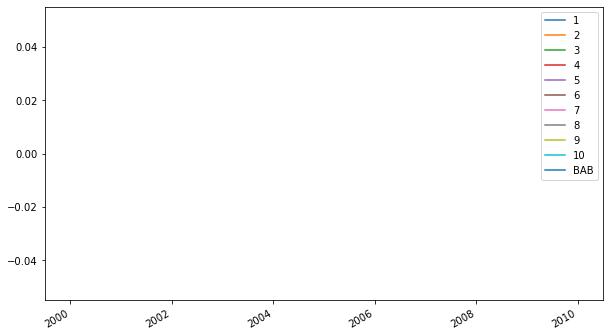

In [1377]:
df_betas.loc['2018-01-01':'2018-12-31'].rolling(1).mean().plot(figsize=(10,6)) # Check if extreme beta still exists

<AxesSubplot:>

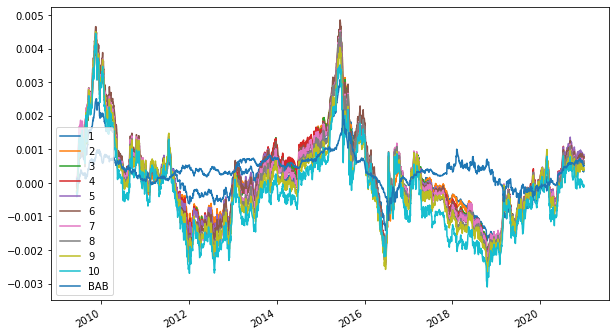

In [1342]:
df_returns.rolling(252).mean().plot(figsize=(10,6))

In [1343]:
df_Port_FF5=df_returns.merge(df_FF_5,left_index=True,right_index=True)
df_Port_FF5 = df_Port_FF5.dropna()

In [1344]:
def get_table_3_4(df):
    df_table_3=pd.DataFrame(index=['Excess Return','CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha','Beta(ex ante)','Beta(realized)','Volatility','Sharpe Ratio'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    df_table_4=pd.DataFrame(index=['CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    
    columns = np.concatenate((np.arange(1,11,1), ['BAB'])).astype(str)

    df_table_3.loc[df_table_3.index=='Excess Return',:]=\
    ((((1+df).cumprod().iloc[-1,:11])**(252/len(df))-1)*100).values/12

    df_table_3.loc[df_table_3.index=='CAPM alpha',:]=\
    [(get_alpha(df,['Mkt-RF'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Three-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Four-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Five-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Beta(ex ante)',:]=\
    df_betas.mean().values

    df_table_3.loc[df_table_3.index=='Beta(realized)',:]=\
    [get_alpha(df,['Mkt-RF'],i)[1] for i in columns]

    df_table_3.loc[df_table_3.index=='Volatility',:]=\
    [df[i].std()*np.sqrt(252)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Sharpe Ratio',:]=\
    (df_table_3.loc['Excess Return']*12/df_table_3.loc['Volatility'])[:].values
    
    df_table_4.loc[df_table_4.index=='CAPM alpha',:]=\
    [get_alpha(df,['Mkt-RF'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Three-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Four-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Five-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[2] for i in columns]

    return df_table_3,df_table_4

In [1345]:
df_Port_FF5.index

DatetimeIndex(['2008-05-30', '2008-06-02', '2008-06-03', '2008-06-04',
               '2008-06-05', '2008-06-06', '2008-06-10', '2008-06-11',
               '2008-06-12', '2008-06-13',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=2940, freq=None)

### All data: 2008-2020

In [1360]:
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5['2008-01-01':'2020-12-31'])

In [1361]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.102162,-0.071379,-0.0881067,-0.0459007,-0.124303,-0.183528,-0.399103,-0.653146,-0.865171,-1.40518,0.686342
CAPM alpha,0.122461,0.0524329,0.0926974,0.171332,0.133539,0.110068,-0.108461,-0.371492,-0.582253,-1.19546,0.742576
Three-factor alpha,0.0977718,0.000484299,0.0270855,0.100406,0.0593373,0.0317415,-0.184812,-0.455836,-0.666243,-1.29223,0.755917
Four-factor alpha,0.103857,0.0132554,0.0323908,0.106718,0.0657468,0.0366399,-0.180301,-0.450063,-0.659251,-1.28763,0.759387
Five-factor alpha,0.114132,0.0271807,0.0456144,0.120205,0.0818517,0.0521443,-0.164894,-0.434715,-0.643212,-1.26949,0.763778
Beta(ex ante),0.583713,0.80115,0.872794,0.921731,0.960864,0.995358,1.02836,1.06395,1.10909,1.19935,0
Beta(realized),0.0614682,0.109561,0.117632,0.130815,0.13048,0.132111,0.138151,0.14567,0.150171,0.161135,-0.00777306
Volatility,13.285,23.1943,26.2049,28.1714,29.9078,31.4066,32.1775,33.1646,34.4381,36.1212,10.0191
Sharpe Ratio,0.09228,-0.0369292,-0.0403467,-0.019552,-0.0498743,-0.0701234,-0.148838,-0.236329,-0.30147,-0.466821,0.822041


In [1362]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,0.361002,0.088436,0.138161,0.23764,0.174273,0.136859,-0.131654,-0.437758,-0.660966,-1.29453,2.89505
Three-factor alpha,0.28818,0.000816926,0.0403908,0.139308,0.0774804,0.0395051,-0.224428,-0.537425,-0.756825,-1.40017,2.95387
Four-factor alpha,0.306522,0.0223637,0.0483422,0.148207,0.085938,0.0456735,-0.219246,-0.531339,-0.750109,-1.39719,2.96918
Five-factor alpha,0.33687,0.0458131,0.0680147,0.166764,0.106898,0.0649438,-0.200344,-0.512714,-0.731268,-1.37666,2.98523
